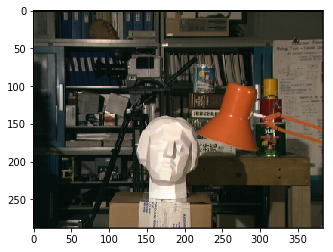

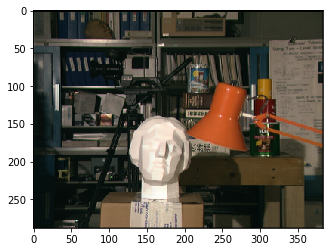

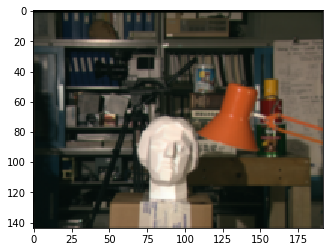

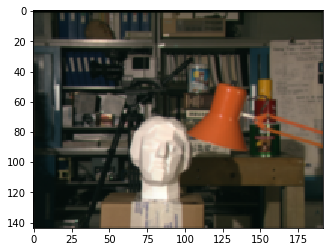

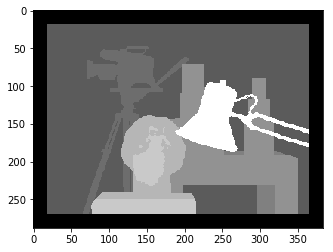

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time


img_01 = cv2.imread('tsukuba/scene1.row3.col1.ppm')
img_02 = cv2.imread('tsukuba/scene1.row3.col2.ppm')
img_01 = cv2.cvtColor(img_01,cv2.COLOR_BGR2RGB)
img_02 = cv2.cvtColor(img_02,cv2.COLOR_BGR2RGB)

img_01down = cv2.pyrDown(img_01)
img_02down = cv2.pyrDown(img_02)
#img_01down = cv2.cvtColor(img_01down,cv2.COLOR_BGR2RGB)
#img_02down = cv2.cvtColor(img_02down,cv2.COLOR_BGR2RGB)

plt.imshow(img_01)
plt.show()

plt.imshow(img_02)
plt.show()

plt.imshow(img_01down)
plt.show()

plt.imshow(img_02down)
plt.show()

truedisp = cv2.imread('tsukuba/truedisp.row3.col3.pgm', 0)
plt.imshow(truedisp, "gray")
plt.show()

# Stereo Correspondence Based on Normalized Cross-Correlation

In [2]:
def pextract(img, y):
    patch = np.empty_like(patch0)
    patches = np.empty_like(patches0)
    for x in range(0, ish[1]):
        a = img[y:y+windowsize,x:x+windowsize,:]
        a=((a[:,:,0]+a[:,:,1]+a[:,:,2])/3).reshape(length)
        patch = (a - np.mean(a)) / np.std(a)
        patches[x] = patch
    return patches

def pextract_lum(img, y):
    patch = np.empty_like(patch0)
    patches = np.empty_like(patches0)
    for x in range(0, ish[1]):
        a = img[y:y+windowsize,x:x+windowsize,:]
        a=(a[:,:,0]*0.3+a[:,:,1]*0.6+a[:,:,2]*0.1).reshape(length)
        patch = (a - np.mean(a)) / np.std(a)
        patches[x] = patch
    return patches

def hpatches(img1, img2, y, mode='intensity'):
    padded1= cv2.copyMakeBorder(img1,pad,pad,pad,pad,cv2.BORDER_CONSTANT)
    padded2= cv2.copyMakeBorder(img2,pad,pad,pad,pad,cv2.BORDER_CONSTANT)
    
    if mode == 'intensity':
        patches1 = pextract(padded1, y)
        patches2 = pextract(padded2, y)
    elif mode == 'luminance':
        patches1 = pextract_lum(padded1, y)
        patches2 = pextract_lum(padded2, y)
    
    return patches1, patches2

def correspondence(img1,img2, wsize = 5, limit = 25, mode='intensity'):
    start = time.clock() 
    global windowsize
    windowsize = wsize
    global pad
    pad = (windowsize-1)//2
    global length
    length = windowsize**2
    global ish
    ish = img1.shape
    global psh
    psh = (img1.shape[0]+2*pad,img1.shape[1]+2*pad)
    global patch0
    patch0 = np.empty((windowsize,windowsize))
    global patches0
    patches0 = np.empty((psh[1]-windowsize+1, length))
    result = np.zeros((ish[0], ish[1]))
    result_nonsqrd = np.zeros((ish[0], ish[1]))
    for y in range(ish[0]):
        #print(y)
        patches1, patches2 = hpatches(img1, img2, y, mode)
        for x in range(ish[1]):
            #normalized cross-correlation
            best = -999
            #pa = patches1[x]
            #a = pa / (np.std(pa) * len(pa))
            r = [0, patches2.shape[0]]
            rr = ish[1]//limit #limits search range
            if x - rr > 0:
                r[0] = x - rr
            if x + rr < ish[1]:
                r[1] = x + rr
            for h in range(r[0],r[1]):
                #b = patches2[h] / patches2[h]
                ncc = np.correlate(patches1[x]/length, patches2[h]) 
                if ncc > best:
                    best = ncc
                    besth =h
            result[y,x]=abs(x-besth)**2
            result_nonsqrd[y,x]=x-besth
            #print(best,ncc, x,y,h, besth)
    elapsed = time.clock()
    elapsed = elapsed - start
    print ("Done. Time spent executing correspondence: ", elapsed)
    return result, result_nonsqrd


#result, result_nonsqrd = correspondence(img_01, img_02, 7)
#result = correspondence(img_01down, img_02down, 7)

Done. Time spent executing correspondence:  22.89821817660857


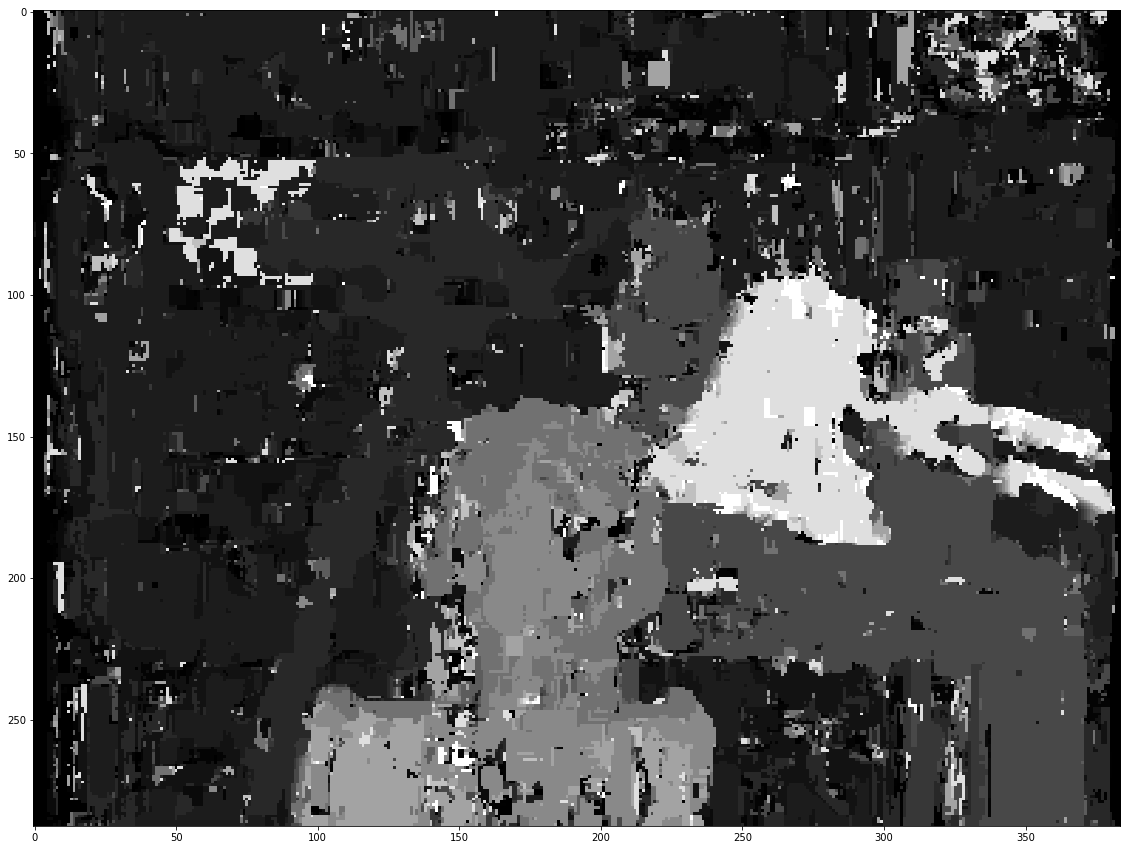

In [3]:
result, result_nonsqrd = correspondence(img_01, img_02, 7)
plt.rcParams['figure.figsize'] = (20.0, 15.0)
plt.imshow(result, "gray")
plt.show()

In [11]:
def tester(test_this, true_disp):
    # expected input shapes: (288, 384)
    old_test_this = test_this
    test_this = test_this/np.max(test_this)
    true_disp = true_disp/np.max(true_disp)
    test = ((test_this - true_disp) * np.max(old_test_this)).reshape(-1)
    mde = test.mean()
    testsq = ((test_this - true_disp) ** 2).reshape(-1)
    mse = testsq.mean()
    print("Mean disparity error:", mde, "\n", "Mean sqared error:", mse)
    stdev = np.std(test)
    print("Standard deviation of disparity error:", stdev)
    i=0
    for x in test:
        if abs(x)>=3:
            i += 1
    p = i/len(test)
    print("Number and fraction of large errors (error ≥ 3 pixels):", i, p)

tester(result, truedisp)

Mean disparity error: -30.7859881366 
 Mean sqared error: 0.0919208937772
Standard deviation of disparity error: 60.8746103226
Number and fraction of large errors (error ≥ 3 pixels): 107087 0.9683069299768519


## just experiments

Done. Time spent executing correspondence:  21.99726172683586


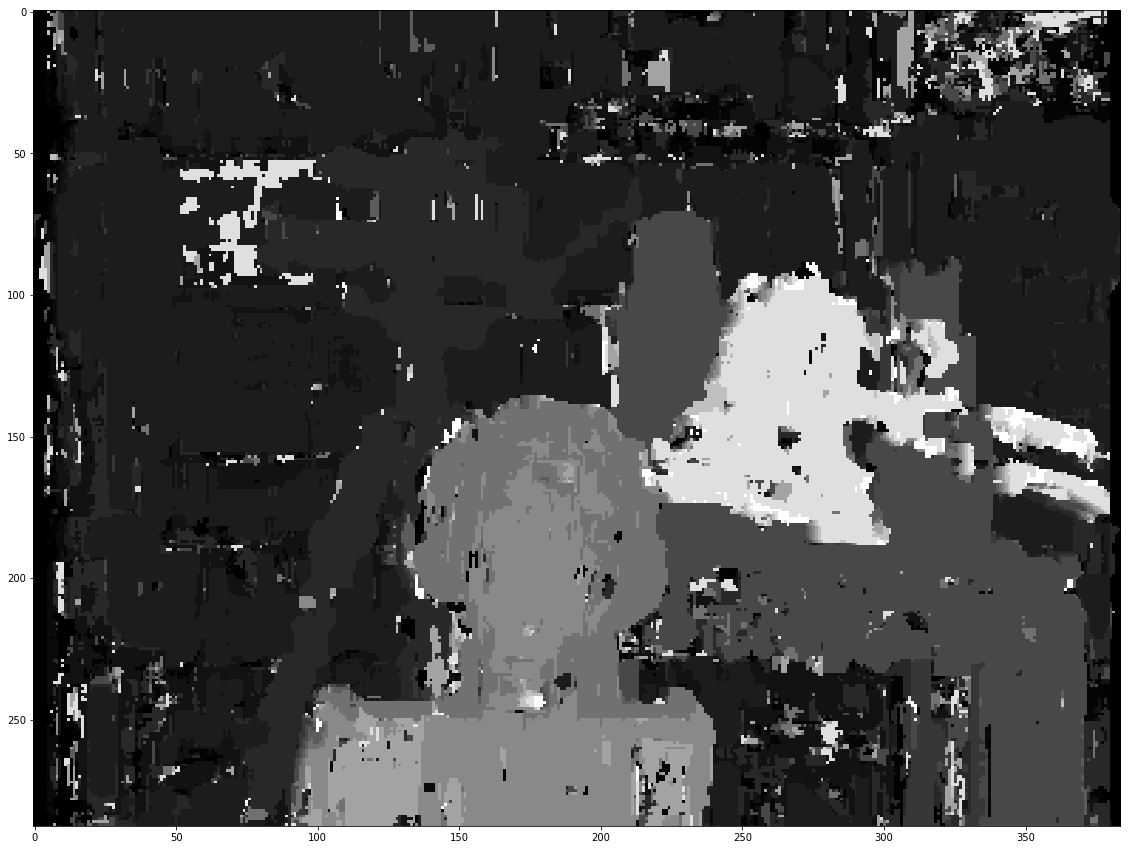

Mean disparity error: -30.7859881366 
 Mean sqared error: 0.0919208937772
Standard deviation of disparity error: 60.8746103226
Number and fraction of large errors (error ≥ 3 pixels): 107087 0.9683069299768519


In [9]:
result, result_nonsqrd = correspondence(img_01, img_02, 7, 25, 'luminance')
plt.rcParams['figure.figsize'] = (20.0, 15.0)
plt.imshow(result, "gray")
plt.show()
tester(result, truedisp)

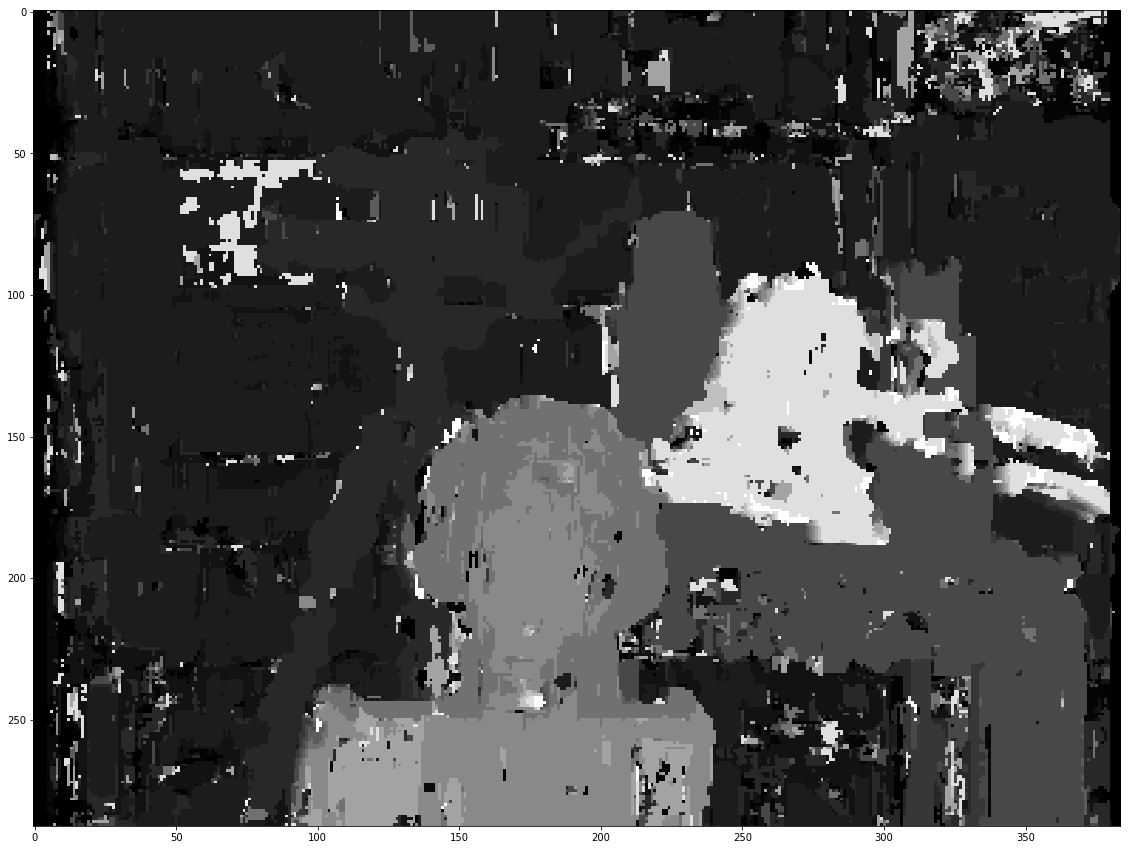

In [6]:
plt.rcParams['figure.figsize'] = (20.0, 15.0)
plt.imshow(result, "gray")
plt.show()
#print(result)

Done. Time spent executing correspondence:  4.737239531547019


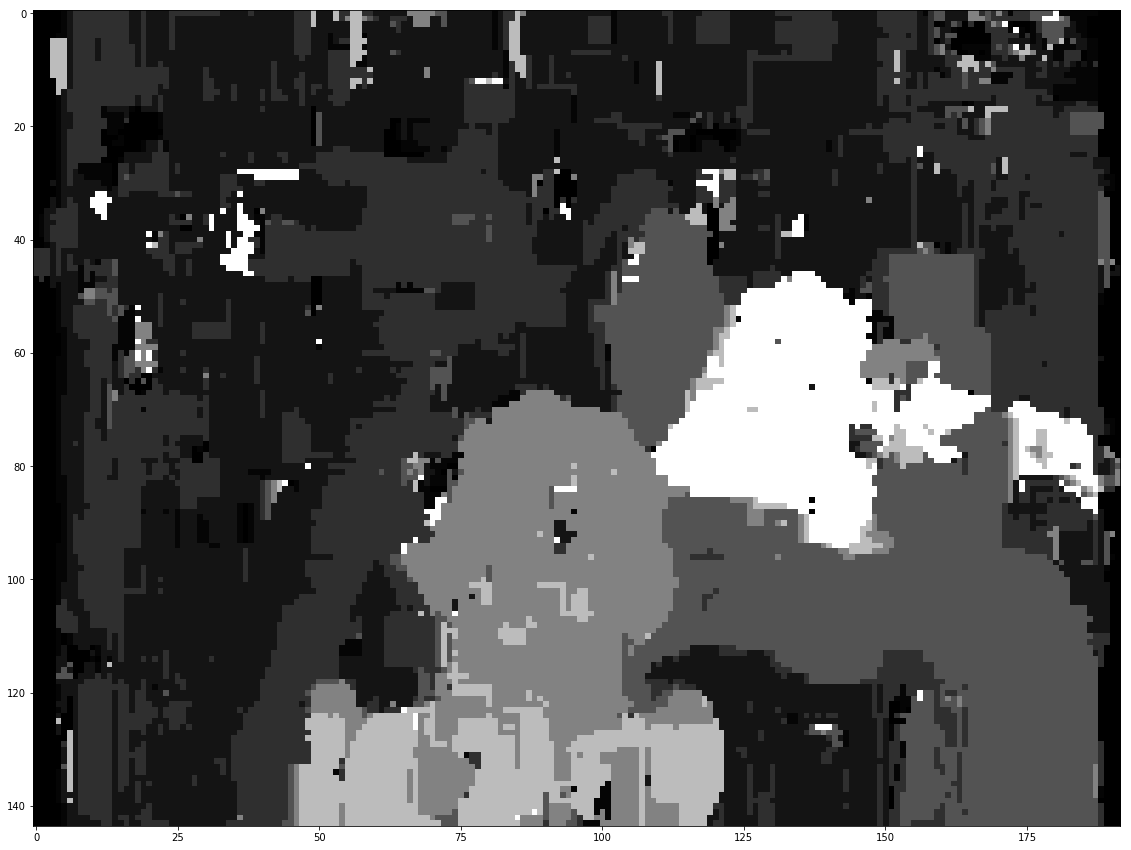

In [7]:
result, resultnon = correspondence(img_01down, img_02down, 7)
plt.imshow(result, "gray")
plt.show()

In [10]:
#just checking data
print(img_01.shape, result.shape, result_nonsqrd.shape, truedisp.shape)
print(np.max(img_01), np.max(result),np.max(result_nonsqrd),np.max(truedisp))
print(np.min(img_01), np.min(result),np.min(result_nonsqrd),np.min(truedisp))
print(np.unique(img_01), np.unique(result),np.unique(result_nonsqrd),np.unique(truedisp))

(288, 384, 3) (288, 384) (288, 384) (288, 384)
254 225.0 15.0 224
0 0.0 -14.0 0
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226